# Combining 4 credit card fraud detection datasets from 3 different organizations into a single classifier 

The goal of this notebook is to demonstrate the feasibility of combining datasets from different sources with different feature encodings. We will show that a model that has access to multiple datasets of the same kind can be significantly more powerful than a model that is trained on only a single dataset.

Let first gain some intuition. The goal of
a classifier $f$ trained on a dataset is to find a mapping from the space
of features $\mathcal{X}$ to the space of labels $\mathcal{Y}$. This can either
be done directly, such that $f : \mathcal{X} \to \mathcal{Y}$

<img src="https://ntropy-figures.s3.us-east-2.amazonaws.com/fig2a.png" alt="Datasets formalism" width = 400/>

, or by first mapping the dataset to some latent space $\mathcal{Z}$ using a
transformation $f_0 : \mathcal{X} \to \mathcal{Z}$, before applying another transformation $f_1 : \mathcal{Z} \to \mathcal{Y}$ to the labels $\mathcal{Y}$. 

<img src="https://ntropy-figures.s3.us-east-2.amazonaws.com/fig2b.png" alt="Datasets formalism" width = 400/>

With infinite amount of data, $f$ and $g = f_1 \circ f_2$ are equivalent. However, when information is
limited, the transforms have errors, namely $f(x) = y + \epsilon(x)$ and
$g(x) = y + \mathcal{O}(\epsilon_0(x) +
\epsilon_1(x))$. For a fixed amount of information, each error grows with the complexity of its respective transform. Equivalently, for a fixed transform complexity, the error decreases with more information.

Now, we can pick a $\mathcal{Z}$, shared across multiple datasets, such that the respective transforms $f_0$ are unique to each dataset, but simple. On the other, the transform $f_1$ is more complex, but the same for all datasets. Now, as it is shared, the more complex $f_1$ can be learned from the combined information of all datasets. The transforms $f_0$ have to be learned using only information in each individual dataset, but are simpler. Hence, the resulting combined error $\epsilon_0(x) + \epsilon_1(x))$ can be much smaller than $\epsilon(x)$ for the original transform $f$.

Datasets in the real world that are of similar types, e.g. transactions, individuals, businesses, etc. tend to also have similar fundamental features. It is therefore reasonable to assume that many of them can be mapped to each other with relatively simple transforms and the assumption outlined above holds. Here we will show this is the case on 4 datasets of credit card transactions from 3 different organizations, FICO, Worldline and Vesta.



First, we need to download and extract features from each dataset. Lets define some helper functions.

In [ ]:
#@title

import pandas as pd
import numpy as np
from os.path import exists
from os import mkdir, environ
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def scale(data, a, b):
    #scale all values to a range
    return MinMaxScaler(feature_range = (a, b)).fit_transform(data)

def encode_cols(data, categorical_cols):
    #one-hot encode labels and remove outlier categories
    for col in categorical_cols:
        counts = data[col].value_counts()
        max_counts = counts.max()
        data[col] = data[col].replace(list(counts[counts < 0.01 * max_counts].keys()), "OUTLIER")
        has_na = data[col].isna().values.any()
        if has_na:
            data[col].fillna("-", inplace=True)
        data[col] = LabelEncoder().fit_transform(data[col].astype(str))
        if not has_na:
            data[col] += 1
        data[col] = data[col].replace(0, np.nan)
    return data

#datasets directory    
if not exists("./datasets"):
    mkdir("./datasets")

#Kaggle credentials. To avoid rate limits, please use your own here.
environ['KAGGLE_USERNAME'] = "iliazin" #Kaggle username
environ['KAGGLE_KEY'] = "d6b031e79ee1df5d927b936a54d44b5c" #Kaggle api key

#install kaggle CLI
! pip install -q kaggle --upgrade

### Dataset 1

Credit card transactions from Worldline.

In [ ]:
#@title

def get_data1():
    print("data0")

    base_dir = "./datasets/2_0"

    #load from checkpoint if it exists
    if exists(base_dir):
        return np.load(base_dir + "/features.npy"), np.load(base_dir + "/labels.npy")

    #download if not found
    if not exists("creditcardfraud"):
        ! mkdir creditcardfraud
        ! kaggle datasets download mlg-ulb/creditcardfraud
        ! unzip creditcardfraud.zip -d creditcardfraud

    #load into pandas dataframe
    data = pd.read_csv("creditcardfraud/creditcard.csv")

    #feature extraction
    labels = data["Class"]
    data = data.drop(columns = ["Time", "Class"])
    data = scale(data, 0, 1)

    data = np.array(data)
    labels = np.array(labels)

    #save to checkpoint
    mkdir(base_dir)
    np.save(base_dir + "/features.npy", data)
    np.save(base_dir + "/labels.npy", labels)

    return data, labels

### Dataset 2

List of credit card transactions from Vesta Corporation.

In [ ]:
#@title

def get_data2():
    print("data1")

    base_dir = "./datasets/2_1"

    #load from checkpoint if it exists
    if exists(base_dir):
        return np.load(base_dir + "/features.npy"), np.load(base_dir + "/labels.npy")

    #download if not found
    if not exists("ieee-fraud-detection"):
        ! mkdir ieee-fraud-detection
        ! kaggle competitions download -c ieee-fraud-detection
        ! unzip train_transaction.csv.zip -d ieee-fraud-detection
        ! unzip train_identity.csv.zip -d ieee-fraud-detection

    #join both transactions and identities into pandas dataframe
    transaction = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
    identity = pd.read_csv("ieee-fraud-detection/train_identity.csv")
    data = transaction.join(identity.set_index("TransactionID"), on="TransactionID")

    #feature engineering
    labels = data["isFraud"]
    data.drop(columns = ["isFraud", "TransactionID", "TransactionDT"], inplace=True)
    categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2", 
                   "P_emaildomain", "R_emaildomain", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", 
                   "DeviceType", "DeviceInfo", "id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", 
                   "id_19", "id_20", "id_21", "id_22", "id_23", "id_24", "id_25", "id_26", "id_27", "id_28", "id_29", 
                   "id_30", "id_31", "id_32", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]

    data = encode_cols(data, categorical)
    data = scale(data, 1, 2)
    data = np.nan_to_num(data)
    data = scale(data, 0, 1)

    data = np.array(data)
    labels = np.array(labels)

    #save to checkpoint
    mkdir(base_dir)
    np.save(base_dir + "/features.npy", data)
    np.save(base_dir + "/labels.npy", labels)

    return data, labels

### Dataset 3

The first dataset form the 2009 UCSD datamining contest. This dataset of credit card transactions was obtained from FICO. 

In [ ]:
#@title

def get_data3():
    print("data2")

    base_dir = "./datasets/2_2"

    #load from checkpoint if available
    if exists(base_dir):
        return np.load(base_dir + "/features.npy"), np.load(base_dir + "/labels.npy")

    #download if does not exist
    if not exists("ucsd-data-mining"):
        ! mkdir ucsd-data-mining
        ! wget https://www.cs.purdue.edu/commugrate/data/credit_card/DataminingContest2009.Task1.Train.Inputs.zip
        ! wget https://www.cs.purdue.edu/commugrate/data/credit_card/DataminingContest2009.Task1.Train.Targets.zip
        ! unzip DataminingContest2009.Task1.Train.Inputs.zip -d ucsd-data-mining
        ! unzip DataminingContest2009.Task1.Train.Targets.zip -d ucsd-data-mining

    #read into pandas dataframe
    data = pd.read_csv("ucsd-data-mining/DataminingContest2009.Task1.Train.Inputs")
    labels = pd.read_csv("ucsd-data-mining/DataminingContest2009.Task1.Train.Targets", header = None)

    #feature engineering
    data.drop(columns = ["total"], inplace=True)
    categorical = ["state1", "zip1", "domain1"]
    data = encode_cols(data, categorical)
    data = scale(data, 1, 2)
    data = np.nan_to_num(data)
    data = scale(data, 0, 1)

    data = np.array(data)
    labels = np.array(labels).flatten()

    #save to checkpoint
    mkdir(base_dir)
    np.save(base_dir + "/features.npy", data)
    np.save(base_dir + "/labels.npy", labels)

    return data, labels

### Dataset 4

The second dataset of credit card transactions from the 2009 UCSD datamining contest. This dataset is also from FICO.

In [ ]:
#@title

def get_data4():
    print("data3")

    base_dir = "./datasets/2_3"

    #load from checkpoint if available
    if exists(base_dir):
        return np.load(base_dir + "/features.npy"), np.load(base_dir + "/labels.npy")

    #download if files not found
    if not exists("ucsd-data-mining"):
        ! wget https://www.cs.purdue.edu/commugrate/data/credit_card/DataminingContest2009.Task2.Train.Inputs.zip
        ! wget https://www.cs.purdue.edu/commugrate/data/credit_card/DataminingContest2009.Task2.Train.Targets.zip
        ! unzip DataminingContest2009.Task2.Train.Inputs.zip -d ucsd-data-mining
        ! unzip DataminingContest2009.Task2.Train.Targets.zip -d ucsd-data-mining

    #load into pandas dataframe
    data = pd.read_csv("ucsd-data-mining/DataminingContest2009.Task2.Train.Inputs")
    labels = pd.read_csv("ucsd-data-mining/DataminingContest2009.Task2.Train.Targets", header = None)

    #feature engineering
    data.drop(columns = ["total", "custAttr1"], inplace=True)
    data["custAttr2"] = data["custAttr2"].apply(lambda x : x.split("@")[1])
    categorical = ["state1", "zip1", "custAttr2"]
    data = encode_cols(data, categorical)
    data = scale(data, 1, 2)
    data = np.nan_to_num(data)
    data = scale(data, 0, 1)

    data = np.array(data)
    labels = np.array(labels).flatten()

    #save to checkpoint
    mkdir(base_dir)
    np.save(base_dir + "/features.npy", data)
    np.save(base_dir + "/labels.npy", labels)

    return data, labels

Splitting datasets into train and test sets. 

In [ ]:
#@title

datasets = [get_data1(), get_data2(), get_data3(), get_data4()]
print("dataset_dims:", [data.shape for data, _ in datasets])

datasets_train, datasets_test= [], []
for data, labels in datasets:
    Nc = int(0.5 * len(data))
    datasets_train.append((data[:Nc], labels[:Nc]))
    datasets_test.append((data[Nc:], labels[Nc:]))

As we are not assuming any shared features between the datasets, we offset each dataset to its own part in the feature vector.

<img src="https://ntropy-figures.s3.us-east-2.amazonaws.com/fig1.png" alt="Dataset offsets" width = 500/>


In [ ]:
#@title

#to total number of features across all datasets
D = sum([data.shape[1] for data, _ in datasets_train])

features_train, labels_train = None, None
datasets_test_p = []
j = 0
for i in range(len(datasets_train)):

    s = datasets_train[i][0].shape

    data_p = np.zeros((s[0],D))
    data_p[:,j:j+s[1]] = datasets_train[i][0]
    
    #decision-tree models can deal with missing values
    data_p[data_p==0] = np.nan

    #we are training on all datasets at once
    if i == 0:
        features_train = data_p
        labels_train = datasets_train[i][1]
    else:
        features_train = np.concatenate([features_train, data_p])
        labels_train = np.concatenate([labels_train, datasets_train[i][1]])

    #the test set needs to be offset in the same way
    data_p = np.zeros((datasets_test[i][0].shape[0],D))
    data_p[:,j:j+s[1]] = datasets_test[i][0]
    data_p[data_p==0] = np.nan

    #we are testing performance on each dataset individually
    datasets_test_p.append((data_p, datasets_test[i][1]))

    j += s[1]
dataset_train_p = (features_train, labels_train)

We comparing performance of a gradient boosting binary classifier on single datasets vs. multiple datasets. We use the [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric, which is an industry standard for classifiers. In a production setting, a number of other metrics would be used in parallel, but ROC AUC is a good proxy. **PS: depending on time of day, this takes up to 40 mins to run.**

In [ ]:
#@title

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def get_score(train_data, valid_data):
    model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, random_state = 50)
    model.fit(train_data[0], train_data[1], early_stopping_rounds = 100, eval_metric = 'auc', 
              eval_set = [valid_data], verbose = False)
    pred_valid = model.predict_proba(valid_data[0], num_iteration = model.best_iteration_)[:, 1]
    return roc_auc_score(valid_data[1], pred_valid)

single, multi = [], []
for i in range(len(datasets_train)):
    score_single = get_score(datasets_train[i], datasets_test[i])
    score_multi = get_score(dataset_train_p, datasets_test_p[i])
    single.append(score_single)
    multi.append(score_multi)
    print(i, score_single, score_multi)

0 0.9690573308581625 0.9788612935517076
1 0.8877738748135325 0.8882632573687904
2 0.79409752793966 0.8356958941515147
3 0.8285903329612337 0.8352114429092057


We can now plot the results.

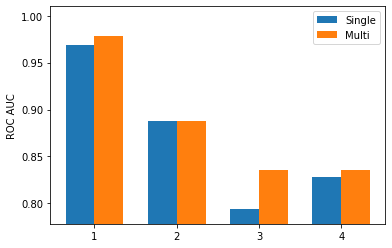

In [20]:
#@title

import matplotlib.pyplot as plt

width = 0.35
inds = np.arange(len(single))
plt.bar(inds, single, width, label='Single')
plt.bar(inds + width, multi, width, label='Multi')
plt.ylim([0.98 * min(multi + single), 1.01])
plt.ylabel('ROC AUC')
plt.xticks(inds + width / 2, [str(i+1) for i in range(len(single))])
plt.legend(loc='best')
plt.show()

It is evident that classifier performance on all 4 datasets can be improved by simply combining it with other datasets. For this experiment, the main criteria for picking datasets was public availability and relevant type of labels and features. Training parameters have been picked once without any further tuning. Playing around with learning rate, regularization and other parameters is likely to improve things further. However, as outlined in the start of this notebook, only datasets of similar types and with similar distributions are likely to be "synergetic". i.e. MNIST is unlikely to help with catching credit card fraud :)

If observations from all datasets are stored in a single database without any privacy or accessibility barriers, a standard classifier, like the one we used above, can easily be trained on the amalgamated data with a few tricks. In reality, however, datasets are scattered across different organizations, which introduces three key complications:

*   **Privacy risk** Datasets are often confidential for legal or
    commercial reasons. The risk of such a dataset being revealed to a third
    party is a liability. This precludes the storing of different
    organizations' datasets in one database for easy training.
*   **Incompatible feature spaces** Feature encodings are proprietary
    to organizations. Disparate datasets will usually have different feature
    encodings, even if they contain similar kinds of information. Engineering
    effort is traditionally required to reconcile those encodings into a shared
    format.
*   **Accessibility** It is very unlikely that all datasets will be
    accessible at the same time. It is unreasonable to require every
    organization to provide a training API that is always available.

All three problems can be addressed using a combined model sequentially trained on all datasets in a privacy-preserving way. At Ntropy we are developing such a model, which will soon be accessible through our [Python SDK](https://github.com/ntropy-network/ntropy-client).

If you have any questions or comments, please do not hesitate to contact us at hello@ntropy.network. We are also [hiring](https://docs.google.com/document/u/1/d/1B0kMa5Gvnq8PIIGNtbk0KDguvRFnGXgJGxjHJUpbpRI).